# Installing packages

In [ ]:
!pip install --upgrade pip
!pip install deeppavlov
!python -m deeppavlov install squad_bert
!pip uninstall tensorflow
!pip install tensorflow-gpu==1.15.2
!pip install transformers==2.8.0

Make sure tensorflow can see GPU

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("="*100)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("="*100)
from tensorflow.python.client import device_lib
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
get_available_gpus()

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5316164094645545790
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17196798317991048707
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5269048422529622879
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338832282
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2618172672517134799
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


['/device:GPU:0']

# Imports

In [ ]:
from deeppavlov.core.data.utils import download
from deeppavlov.dataset_readers.basic_classification_reader import BasicClassificationDatasetReader
from deeppavlov.dataset_iterators.basic_classification_iterator import BasicClassificationDatasetIterator

from deeppavlov.models.preprocessors.bert_preprocessor import BertPreprocessor
from deeppavlov.models.preprocessors.torch_transformers_preprocessor import TorchTransformersPreprocessor

from deeppavlov.core.data.simple_vocab import SimpleVocabulary
from deeppavlov.models.preprocessors.one_hotter import OneHotter
from deeppavlov.models.classifiers.proba2labels import Proba2Labels
from deeppavlov.models.bert.bert_classifier import BertClassifierModel
from deeppavlov.metrics.accuracy import sets_accuracy
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
prob2labels = Proba2Labels(max_proba=True)

from sklearn.metrics import classification_report

import pandas as pd
from sklearn.model_selection import train_test_split
import os

import numpy as np
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


# Handling data

In [ ]:
def round_val(val):
    return round(val)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("/content/drive/MyDrive/colab_files/Publication_v1/hybrid/Appropriateness.csv")

In [ ]:
df = pd.read_csv("Appropriateness.csv")


In [ ]:
df.head()

,text,inappropriate,human_labeled,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,none,toxic_new
0,хреногоу меня и детей нет чтоб алименты оформи...,0.21,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.094593
1,"Хм. Боюсь спросить, d тоже, как и W должен пер...",0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.089695
2,Мог бы зарегистрироваться на каком-нибудь модн...,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.326740
3,Потому что без таких мелочей в игру становится...,0.16,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.008725
4,"в этом и психотип игромана, заморочиться, а ес...",0.00,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.021771


# Startifying data

In [ ]:
len(df)

82063

In [ ]:
THRESHOLD = 0.75
df_unsafe = df[df['inappropriate'] > THRESHOLD]
df_safe = df[df['inappropriate'] <= THRESHOLD]

In [ ]:
rs = 0
df_unsafe_shuf = df_unsafe.sample(frac=1, random_state = rs).reset_index(drop=True)
split_train = int(len(df_unsafe_shuf) * 0.8)
split_val = int(len(df_unsafe_shuf) * 0.9)
df_unsafe_shuf_train = df_unsafe_shuf[:split_train]
df_unsafe_shuf_val = df_unsafe_shuf[split_train:split_val]
df_unsafe_shuf_test= df_unsafe_shuf[split_val:]

df_safe_shuf = df_safe.sample(frac=1, random_state = rs).reset_index(drop=True)
split_train = int(len(df_safe_shuf) * 0.8)
split_val = int(len(df_safe_shuf) * 0.9)
df_safe_shuf_train = df_safe_shuf[:split_train]
df_safe_shuf_val = df_safe_shuf[split_train:split_val]
df_safe_shuf_test = df_safe_shuf[split_val:]

df_tr = pd.concat([df_unsafe_shuf_train, df_safe_shuf_train])
df_val = pd.concat([df_unsafe_shuf_val, df_safe_shuf_val])
df_test = pd.concat([df_unsafe_shuf_test, df_safe_shuf_test])

train_path = "train.csv"
val_path = "val.csv"
test_path = "test.csv"

df_tr.to_csv(train_path, index = None)
df_val.to_csv(val_path, index = None)
df_test.to_csv(test_path, index = None)

In [ ]:
len(df_tr) + len(df_val) + len(df_test),

82063

In [ ]:
df_sanity_check = pd.concat([df_tr,df_val,df_test])
df_sanity_check.drop_duplicates(keep = 'first', subset = ['text'], inplace = True)

In [ ]:
len(df_sanity_check)

82063

# Adjusting data

In [ ]:
df = df[(df['inappropriate'] >= 0.8)|(df['inappropriate'] <= 0.2)]
df_val = df_val[(df_val['inappropriate'] >= 0.8)|(df_val['inappropriate'] <= 0.2)]
df_test = df_test[(df_test['inappropriate'] >= 0.8)|(df_test['inappropriate'] <= 0.2)]

df['inappropriate'] = df['inappropriate'].apply(round_val)
df_val['inappropriate'] = df_val['inappropriate'].apply(round_val)
df_test['inappropriate'] = df_test['inappropriate'].apply(round_val)
df.head()

,text,inappropriate,human_labeled,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,terrorism,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,none,toxic_new
1,"Хм. Боюсь спросить, d тоже, как и W должен пер...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.089695
2,Мог бы зарегистрироваться на каком-нибудь модн...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.326740
3,Потому что без таких мелочей в игру становится...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.008725
4,"в этом и психотип игромана, заморочиться, а ес...",0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.021771
5,"Фотку с самим собой и своим же автографом, мак...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.267464


In [ ]:
!mkdir data

In [ ]:
df.to_csv("./data/train.csv", sep = ',', index = None)
df_val.to_csv("./data/val.csv", sep = ',', index = None)
df_test.to_csv("./data/test.csv", sep = ',', index = None)

In [ ]:
reader = BasicClassificationDatasetReader()
data = reader.read(data_path="./data", 
                   train="train.csv", valid="val.csv",test = 'test.csv' ,
                   x="text", y="inappropriate")

In [ ]:
iterator = BasicClassificationDatasetIterator(data, shuffle=True)

# Initialize model

In [ ]:
!wget http://files.deeppavlov.ai/deeppavlov_data/bert/ru_conversational_cased_L-12_H-768_A-12.tar.gz
!tar -xf ru_conversational_cased_L-12_H-768_A-12.tar.gz

In [ ]:
PRETR_BERT_PATH = "./ru_conversational_cased_L-12_H-768_A-12"

In [ ]:
bert_preprocessor = BertPreprocessor(vocab_file=os.path.join(PRETR_BERT_PATH,"vocab.txt"),
                                     do_lower_case=False,
                                     max_seq_length=256)

In [ ]:
input_features = bert_preprocessor(["мама мыла раму"])
print(input_features[0].tokens)
print(input_features[0].input_ids)
print(input_features[0].input_mask)
print(input_features[0].input_type_ids)

['[CLS]', 'мама', 'мыла', 'раму', '[SEP]']
[101, 4775, 49053, 53954, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
vocab = SimpleVocabulary(save_path="./binary_classes.dict")

2021-03-04 15:17:08.676 WARNING in 'deeppavlov.core.models.serializable'['serializable'] at line 49: No load path is set for SimpleVocabulary in 'infer' mode. Using save path instead


In [ ]:
vocab.fit(iterator.get_instances(data_type="train")[1])

In [ ]:
list(vocab.items())

[('0', 0), ('1', 1)]

In [ ]:
one_hotter = OneHotter(depth=vocab.len, 
                       single_vector=True
                      )

In [ ]:
# MODEL_PATH = "/content/drive/MyDrive/colab_files/Publication_v1/hybrid/appropriateness_model/model"
MODEL_PATH = 

In [ ]:
bert_classifier = BertClassifierModel(
    n_classes=vocab.len,
    return_probas=True,
    one_hot_labels=True,
    bert_config_file=os.path.join(PRETR_BERT_PATH,"bert_config.json"),
    pretrained_bert=os.path.join(PRETR_BERT_PATH,"bert_model.ckpt"),
    save_path=MODEL_PATH,
    load_path=MODEL_PATH,
    keep_prob=0.5,
    learning_rate=1e-05,
    learning_rate_drop_patience=5,
    learning_rate_drop_div=2.0
)







The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Use standard file APIs to check for files with this prefix.


2021-03-04 15:17:30.373 INFO in 'deeppavlov.models.bert.bert_classifier'['bert_classifier'] at line 99: [initializing model with Bert from /content/ru_conversational_cased_L-12_H-768_A-12/bert_model.ckpt]



INFO:tensorflow:Restoring parameters from /content/ru_conversational_cased_L-12_H-768_A-12/bert_model.ckpt


# Set validation function

In [ ]:
def roc_auc(y_test,y_pred_tag):
    print("y_test", y_test[:100])

    y_pred_tag = [list(i)[1] for i in y_pred_tag]
    y_pred_tag_print = [round(i,2) for i in y_pred_tag]
    print("y_pred_tag", y_pred_tag_print[:100])
    roc_auc = roc_auc_score(y_test, y_pred_tag)
    return roc_auc

# Start training

Train: 100%|█████████▉| 4675/4676 [2:17:13<00:01,  1.75s/it, epoch=0, loss=0.288]

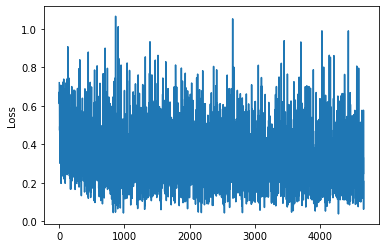

Train: 4677it [2:17:15,  1.35s/it, epoch=0, loss=0.285]                          
valid:   0%|          | 0/471 [00:00<?, ?it/s]


validating .... 


valid: 472it [04:32,  2.18it/s]                         2021-03-04 17:39:22.21 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 75: [saving model to /content/drive/MyDrive/colab_files/Publication_v1/hybrid/appropriateness_model/model]


y_test ['0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0']
y_pred_tag [0.15, 0.18, 0.24, 0.0, 0.0, 0.0, 0.92, 0.03, 0.07, 0.35, 0.0, 0.02, 0.07, 0.0, 0.0, 0.7, 0.12, 0.35, 0.03, 0.06, 0.09, 0.0, 0.01, 0.0, 0.01, 0.8, 0.01, 0.22, 0.33, 0.0, 0.01, 0.1, 0.0, 0.01, 0.03, 0.03, 0.07, 0.0, 0.06, 0.0, 0.93, 0.0, 0.01, 0.0, 0.04, 0.07, 0.0, 0.01, 0.0, 0.17, 0.49, 0.05, 0.0, 0.03, 0.05, 0.01, 0.0, 0.02, 0.18, 0.78, 0.37, 0.1, 0.68, 0.16, 0.01, 0.98, 0.01, 0.06, 0.55, 0.2, 0.94, 0.0, 0.0, 0.67, 0.19, 0.73, 0.24, 0.15, 0.32, 0.64, 0.01, 0.95, 0.0, 0.0, 0.4

Train: 4677it [2:21:52,  1.82s/it, epoch=0, loss=0.285]

New best score. Saving model.



Train:   7%|▋         | 315/4676 [09:13<2:08:30,  1.77s/it, epoch=1, loss=0.201]

KeyboardInterrupt: ignored

In [ ]:
best_score = 0
patience = 2
impatience = 0
BATCH_SIZE = 16

DF_IN_USE = df
plot_every = int(len(df)/BATCH_SIZE)

# let's train for 3 epochs
for ep in range(30):
  
    nbatches = 0
    # for instance in list(tqdm._instances):
    #   tqdm._decr_instances(instance)
    progress_bar = tqdm(total=int(len(df)/BATCH_SIZE), desc='Train')
    train_loss = []
    for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                     data_type="train", shuffle=True):
        x_feat = bert_preprocessor(x)
        y_onehot = one_hotter(vocab(y))
        loss_dict = bert_classifier.train_on_batch(x_feat, y_onehot)
        train_loss.append(loss_dict['loss'])
        nbatches += 1
  
        if nbatches%plot_every == 0:
          plt.plot(train_loss)
          plt.ylabel('Loss')
          plt.show() 

        progress_bar.set_postfix(epoch = ep,loss = np.mean(train_loss[-100:]))     
        progress_bar.update()

    y_valid_trues = []
    y_valid_preds = []
    progress_bar_valid = tqdm(total=int(len(df_val)/BATCH_SIZE), desc='valid')
    for instance in list(tqdm._instances):
          tqdm._decr_instances(instance)
    print("validating .... ")
    for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                        data_type="valid", shuffle=True):
            y_valid_pred = bert_classifier(bert_preprocessor(x))
            y_valid_preds.extend(y_valid_pred)

            y_valid_trues.extend(y)
            progress_bar_valid.update()
    
   
    score = roc_auc(y_valid_trues, y_valid_preds)

    y_valid = np.array([int(float(i)) for i in y_valid_trues])
    pr = vocab(prob2labels(y_valid_preds))
    y_valid_pred = np.array([int(float(i)) for i in pr])

    pr, rec, f, _ = precision_recall_fscore_support(y_valid, y_valid_pred, average='weighted')
    print("roc_auc", score)
    print("precision", pr)
    print("recall", rec)
    print("fscore_weighted", f)
    print("acc", accuracy_score(y_valid, y_valid_pred))

    print("Epochs done: {}. Valid roc_auc: {}".format(ep + 1, score))
    if score > best_score:
        bert_classifier.save()
        print("New best score. Saving model.")
        best_score = score    
        impatience = 0
    else:
        impatience += 1
        if impatience == patience:
            print("Out of patience. Stop training.")
            break

#Final validations

In [ ]:
BATCH_SIZE = 16
y_valid_trues = []
y_valid_preds = []
progress_bar_valid = tqdm(total=int(len(df_val)/BATCH_SIZE), desc='valid')
for instance in list(tqdm._instances):
      tqdm._decr_instances(instance)
for x, y in iterator.gen_batches(batch_size=BATCH_SIZE, 
                                    data_type="test", shuffle=True):
        y_valid_pred = bert_classifier(bert_preprocessor(x))
        y_valid_preds.extend(y_valid_pred)

        y_valid_trues.extend(y)
        progress_bar_valid.update()



valid:   0%|          | 0/471 [00:00<?, ?it/s]
valid: 472it [14:05,  1.79s/it]
valid:  99%|█████████▉| 466/471 [04:28<00:02,  1.91it/s]

In [ ]:
score = roc_auc(y_valid_trues, y_valid_preds)
y_valid = np.array([int(float(i)) for i in y_valid_trues])
pr = vocab(prob2labels(y_valid_preds))
y_valid_pred = np.array([int(float(i)) for i in pr])
pr, rec, f, _ = precision_recall_fscore_support(y_valid, y_valid_pred, average='weighted')
print("roc_auc", score)
print("precision", pr)
print("recall", rec)
print("fscore_weighted", f)
print("accuracy", accuracy_score(y_valid, y_valid_pred))
print(classification_report(y_valid, y_valid_pred))


y_test ['1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '1', '0', '0', '1', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '1']
y_pred_tag [0.98, 0.01, 0.11, 0.0, 0.05, 0.0, 0.08, 0.22, 0.0, 0.0, 0.09, 0.02, 0.03, 0.0, 0.02, 0.98, 0.0, 0.0, 0.02, 0.01, 0.01, 0.0, 0.11, 0.03, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06, 0.01, 0.0, 0.02, 0.0, 0.97, 0.09, 0.0, 0.03, 0.02, 0.11, 0.97, 0.0, 0.1, 0.0, 0.06, 0.0, 0.03, 0.0, 0.22, 0.0, 0.35, 0.0, 0.01, 0.36, 0.51, 0.0, 0.32, 0.69, 0.02, 0.05, 0.01, 0.0, 0.08, 0.99, 0.0, 0.02, 0.0, 0.01, 0.15, 0.28, 0.01, 0.01, 0.54, 0.91, 0.03, 0.0, 0.98, 0.0, 0.0, 0.09, 0.0, 0.0, 0.7, 0.65